In [1]:
import pymeshlab
import numpy as np
from IPython import display

In [2]:
def angle(a, b, c): #ingresamos los 3 puntos del triangulo y nos devulve la cotangente
    #devuelve del angulo de enmedio
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cos_angle) #angulo en radianes
    return angle

In [3]:
def obtuso(a, b, c):
    an2 = angle(a, b, c)
    an1 = angle(b, a, c)
    an3 = angle(a, c, b)
    if(an1 > np.pi/2):
        return 1
    if(an2 > np.pi/2):
        return 2
    if(an3 > np.pi/2):
        return 3
    return 0

In [4]:
def cotangente(a,b,c):
    an = angle(a, b, c)
    cos_angle = np.sin(an)
    sin_angle = np.sin(an)
    return cos_angle/sin_angle

In [5]:
def area(v0, v1, v2): #area con formula de heron
    a = np.linalg.norm(v0-v1)
    b = np.linalg.norm(v2-v1)
    c = np.linalg.norm(v0-v2)
    s = (a+b+c)/2
    return np.sqrt(s*(s-a)*(s-b)*(s-c))

Sabemos que 
$$A_{voronoi} = \frac{1}{8}\sum_{v_j\in N_1(v_i)}(\cot\alpha_{ij} + \cot\beta_{ij})||x_i - x_j||^2 $$

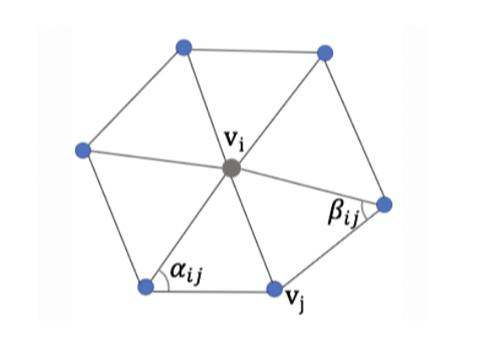

In [6]:
display.Image("./voronoi.jpg", width=300)

Notemos que si iteramos por cada cara, entonces podemos sumar una parte del area Voronoi a cada vertice de esa cara. Por lo que definimos la siguiente funcion que itera por caras.

In [7]:
def area_cell(s): 
#Le pasamos el string del numbre del mesh que usaremos (debe estar en la misma carpeta que este archivo)
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    voronoi = np.zeros(n_vertex) #creamos el arreglo que vamos a devolver, este es del tamaño de vertices
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    angles_v = np.zeros(n_vertex)
    
    for i in range(n_faces): #Por cada cara
        #Guarda el indice de cada uno de los vertces que conforman la cara
        v0_in = faces[i][0]
        v1_in = faces[i][1]
        v2_in = faces[i][2]
        
        #Guarda las posiciones 3D de los vertices
        v0 = vertex[v0_in]
        v1 = vertex[v1_in]
        v2 = vertex[v2_in]
        
        #Guarda los angulos que forman en radianes
        a_0 = angle(v1, v0, v2)
        a_1 = angle(v0, v1, v2)
        a_2 = angle(v0, v2, v1)
        
        #Guarada la suma total de angulos
        angles_v[v0_in] += a_0
        angles_v[v1_in] += a_1
        angles_v[v2_in] += a_2
        
        #calculamos el cotangente
        cot_0 = np.cos(a_0)/np.sin(a_0)
        cot_1 = np.cos(a_1)/np.sin(a_1)
        cot_2 = np.cos(a_2)/np.sin(a_2)
        
        #checamos si es obtuso el angulo, y nos devuelve cual es el obtuso
        ob = obtuso(v0, v1, v2)
        #calculamos el area del triangulo
        area_t = area(v0, v1, v2)
        
        if(ob == 0): #Si no tiene ningun angulo obtuso, a cada angulo le sumamos el area correspondiente
            voronoi[v0_in] += (1/8)*(cot_1)*(np.linalg.norm(v0-v2))**2
            voronoi[v0_in] += (1/8)*(cot_2)*(np.linalg.norm(v0-v1))**2
            
            voronoi[v1_in] += (1/8)*(cot_0)*(np.linalg.norm(v1-v2))**2
            voronoi[v1_in] += (1/8)*(cot_2)*(np.linalg.norm(v1-v0))**2
            
            voronoi[v2_in] += (1/8)*(cot_0)*(np.linalg.norm(v2-v1))**2
            voronoi[v2_in] += (1/8)*(cot_1)*(np.linalg.norm(v2-v0))**2
        else:
            if(ob == 1):
                voronoi[v0_in] += area_t/2 #Si es el vertice central el que es obtuso, el area es /2
                voronoi[v1_in] += area_t/4
                voronoi[v2_in] += area_t/4
            if(ob == 2):
                voronoi[v0_in] += area_t/4
                voronoi[v1_in] += area_t/2
                voronoi[v2_in] += area_t/4
            if(ob == 3):
                voronoi[v0_in] += area_t/4
                voronoi[v1_in] += area_t/4
                voronoi[v2_in] += area_t/2
    return voronoi, angles_v #devuelve el area voronoi y la suma de angulos al rededor de un vertice

Realice la implementacion de esta manera pues no tenia informacion de los anillos de cada vertice me di cuenta que calcular eso era mas tardado que hacerlo de esta manera.
Ya que pasaremos una vez por cada vertice de cada cara, es decir 20mil por 3.
Pero suponiendo que ya tenemos los anillos, seria pasar por 6 vertices por cada vertice, es decir, 10mil por 6.
Lo cual al final nos deja con casi lo mismo si ya tuvieramos los anillo. Pero al no tenerlos, es mejor hacerlo asi.

In [8]:
def laplace_beltrami_matrix(s):
    #Le pasamos el string del numbre del mesh que usaremos (debe estar en la misma carpeta que este archivo)
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    voronoi, angles = area_cell(s)
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    
    M = np.zeros((n_vertex, n_vertex))
    C = np.zeros((n_vertex, n_vertex))
    
    for i in range(n_faces): #Por cada cara 
        v0_in = faces[i][0]
        v1_in = faces[i][1]
        v2_in = faces[i][2]
        
        v0 = vertex[v0_in]
        v1 = vertex[v1_in]
        v2 = vertex[v2_in]
        
        cot_0 = cotangente(v1, v0, v2)
        cot_1 = cotangente(v0, v1, v2)
        cot_2 = cotangente(v0, v2, v1)
        
        ob = obtuso(v0, v1, v2)
        area_t = area(v0, v1, v2)
        
        if(M[v0_in][v0_in] == 0):
            M[v0_in][v0_in] = voronoi[v0_in]
        if(M[v1_in][v1_in] == 0):
            M[v1_in][v1_in] = voronoi[v1_in]
        if(M[v2_in][v2_in] == 0):
            M[v2_in][v2_in] = voronoi[v2_in]
        
        C[v0_in][v1_in] += (0.5)*cot_2
        C[v0_in][v2_in] += (0.5)*cot_1
        C[v0_in][v0_in] -= (0.5)*(C[v0_in][v1_in] + C[v0_in][v2_in])
        
        C[v1_in][v0_in] += (0.5)*cot_2
        C[v1_in][v2_in] += (0.5)*cot_0
        C[v1_in][v1_in] -= (0.5)*(C[v1_in][v0_in] + C[v1_in][v2_in])
        
        C[v2_in][v0_in] += (0.5)*cot_1
        C[v2_in][v1_in] += (0.5)*cot_0
        C[v2_in][v2_in] -= (0.5)*(C[v2_in][v0_in] + C[v2_in][v1_in])
        
    return np.linalg.inv(M)@C
 

In [9]:
def gaussian_curvature(s):
    voronoi, angles = area_cell(s)
    
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    K = np.zeros(n_vertex)

    for i in range(n_vertex):
        K[i] = (1/voronoi[i])*(2*np.pi - angles[i])
    
    return K

In [10]:
def mean_curvature(s):
    L = laplace_beltrami_matrix(s)
    
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    vertex_normals = ms.current_mesh().vertex_normal_matrix() #guardamos las normales de los vertices
    M = np.zeros(n_vertex)
    direccion_L = L@vertex #Aplicamos el operador laplaciano a cada vertice

    for i in range(n_vertex):
        M[i] = np.linalg.norm(L[i]) #Usamos la norma del laplaciano discreto 
        if(np.dot(direccion_L[i],vertex_normals[i]) < 0): #vemos si la direcciones coinciden o no
            M[i] = -M[i]
    return M

In [11]:
def colorize(T):
    colors = np.ones((len(T),4))
    m = np.amin(T)/50
    M = np.amax(T)/50
    
    for i in range(len(T)):
        if(T[i] < 0):
            if(T[i]<m):
                colors[i][0] = 0
                colors[i][1] = 0
            else:
                colors[i][0] = (m-T[i])/m
                colors[i][1] = (m-T[i])/m
                
        if(T[i] > 0):
            if(T[i]>M):
                colors[i][1] = 0
                colors[i][2] = 0
            else:
                colors[i][1] = (M-T[i])/M
                colors[i][2] = (M-T[i])/M
                
    
    return colors

In [12]:
def color(s, colors, new_name): #esta funcion nos genera el mesh con los colores ya agregados
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    
    #Creamos una mesh nueva con los arreglos
    m2 = pymeshlab.Mesh(vertex_matrix=vertex, face_matrix=faces, v_color_matrix=colors)
    ms.add_mesh(m2, new_name)
    
    ms.save_current_mesh(new_name)

In [13]:
K = gaussian_curvature("sphere.obj")
colors = colorize(K)
color("sphere.obj", colors, "gaussian_curvature_sphere.obj")

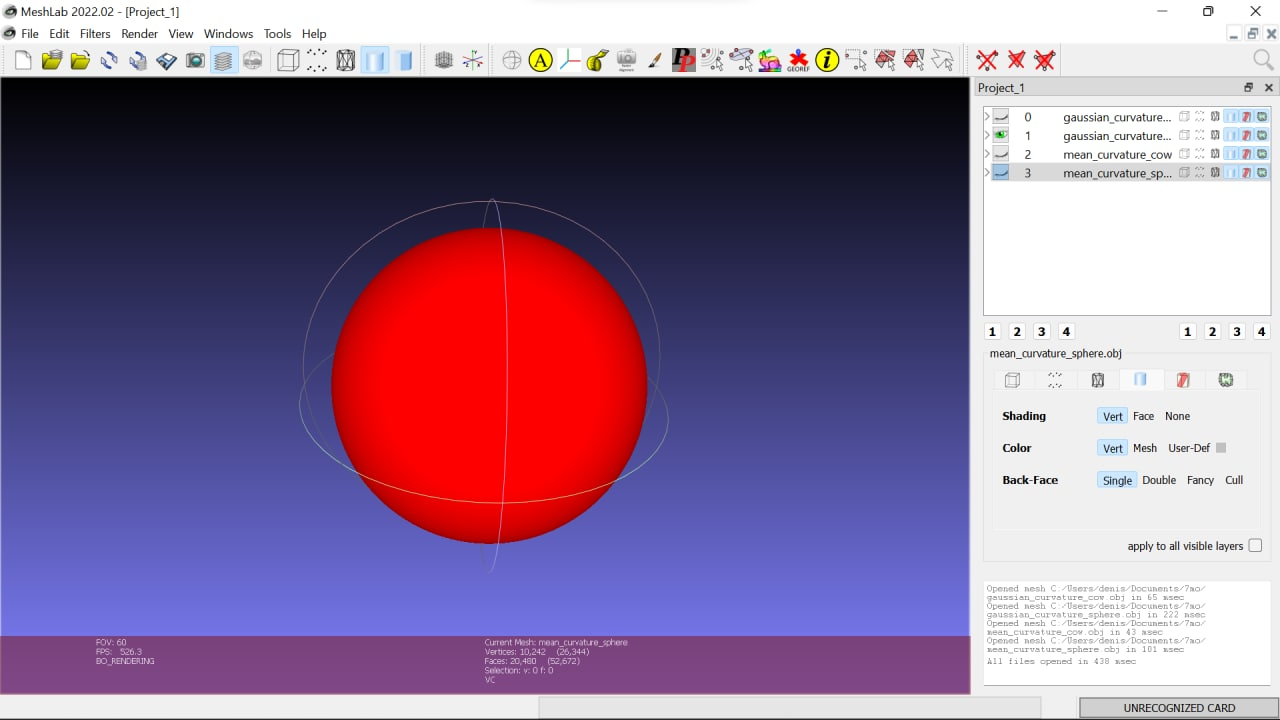

In [14]:
display.Image("./gaussiansphere.jpg")

In [15]:
M = mean_curvature("sphere.obj")
colors = colorize(M)
color("sphere.obj", colors, "mean_curvature_sphere.obj")

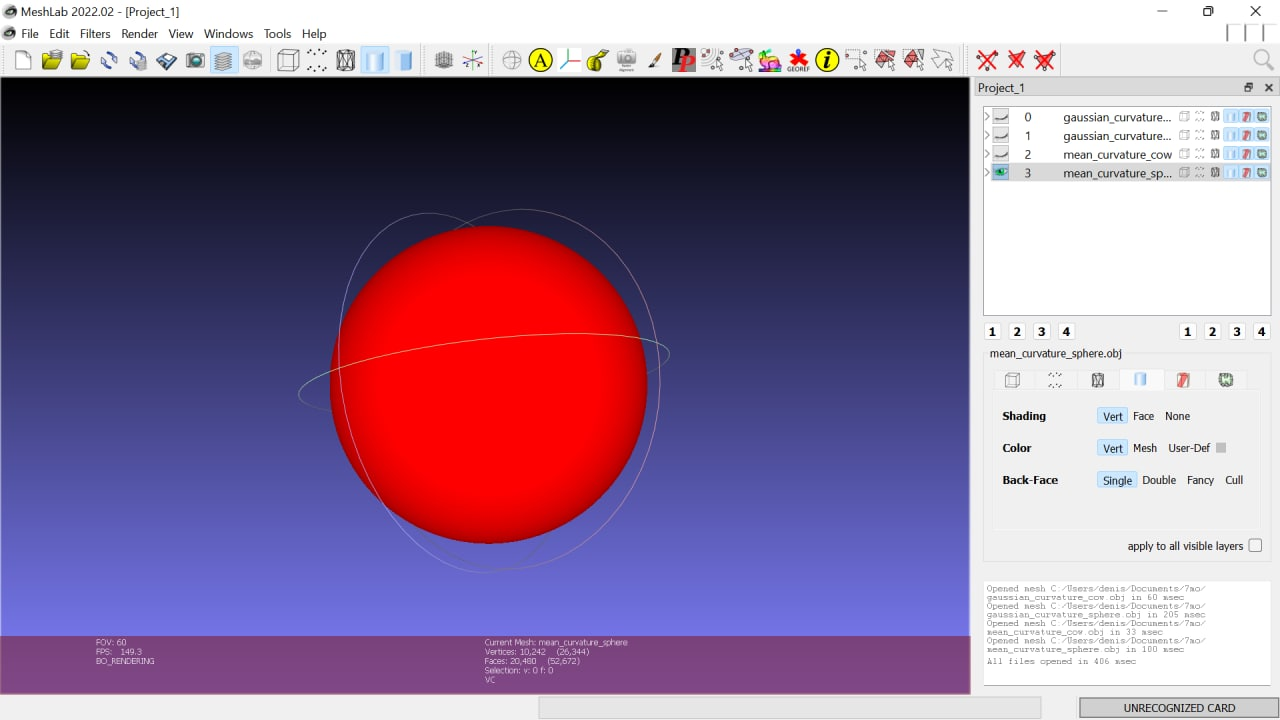

In [16]:
display.Image("./meansphere.jpg")

In [17]:
K = gaussian_curvature("cow.obj")
colors = colorize(K)
color("cow.obj", colors, "gaussian_curvature_cow.obj")

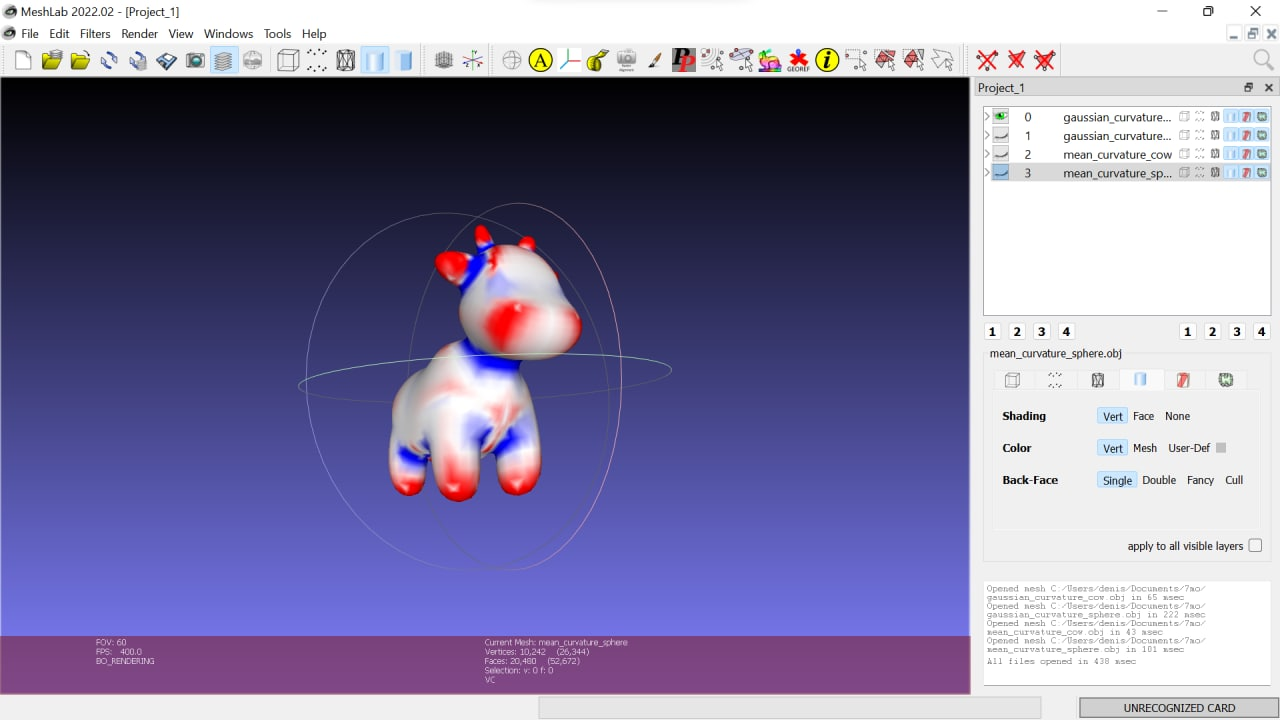

In [18]:
display.Image("./gaussiancow.jpg")

In [19]:
M = mean_curvature("cow.obj")
colors = colorize(M)
color("cow.obj", colors, "mean_curvature_cow.obj")

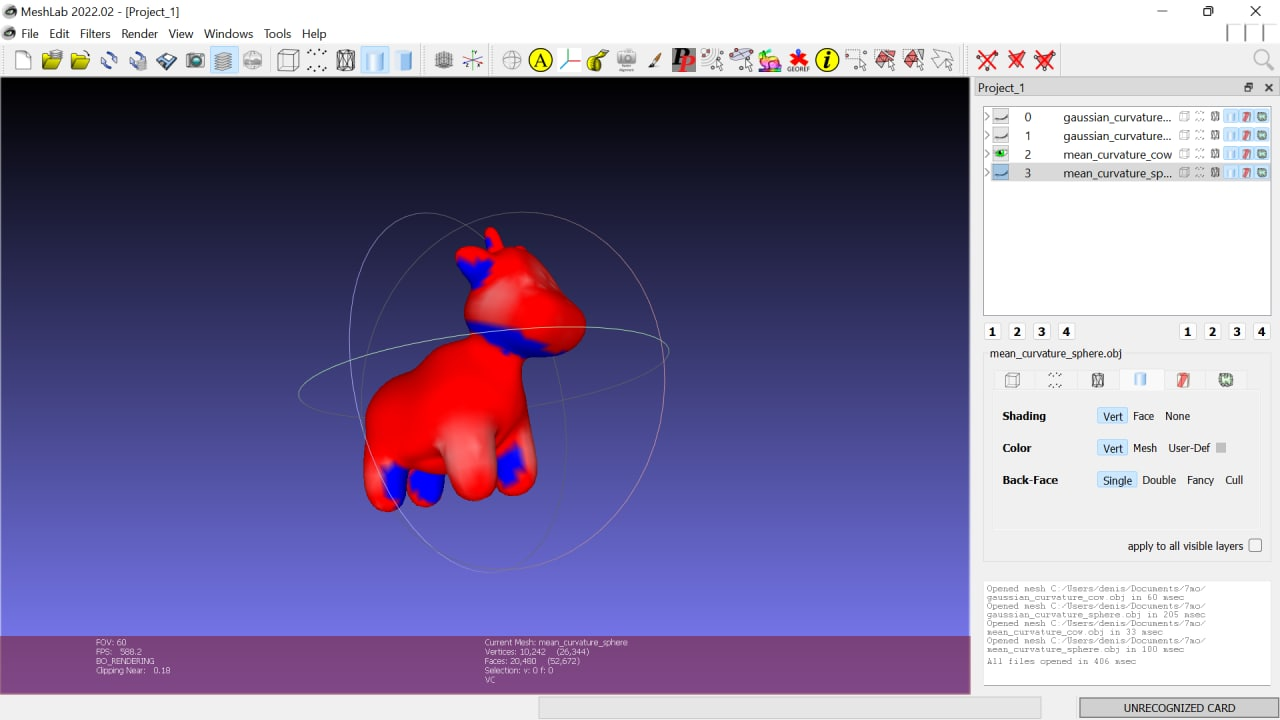

In [20]:
display.Image("./meancow.jpg")